<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers

from transformers import TFMT5ForConditionalGeneration, MT5Tokenizer, DataCollatorForSeq2Seq

In [2]:
print(tf.__version__)

2.17.1


# 1. Duomenų paruošimas

Atliksime sentimentų analizę, naudojant iš anksto apmokytą BERT modelį.

Naudosime duomenis iš [Yelp Open Dataset](https://www.yelp.com/dataset). Tai bus atsiliepimai apie maisto restoranus.

In [3]:
!pip install datasets -q

from datasets import load_dataset

hfDataset = load_dataset("antash420/text-summarization-alpaca-format")
hfDataset.save_to_disk("/content/hfDataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Saving the dataset (0/6 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13368 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
print("Input: ", hfDataset['test']['input'][0])
print("Output: ", hfDataset['test']['output'][0])

Input:  (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's cere

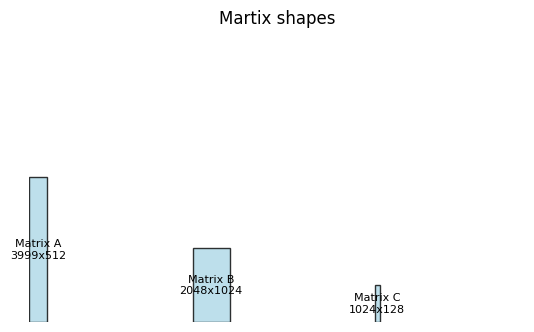

In [5]:
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


In [6]:
from tensorflow.keras.initializers import RandomNormal
initializer = RandomNormal(mean=0.0, stddev=0.05, seed=42)

tokenizer = MT5Tokenizer.from_pretrained("google/t5-efficient-mini", legacy=False)
model = TFMT5ForConditionalGeneration.from_pretrained("google/t5-efficient-mini")

text = """LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. "I'll definitely have some sort of party," he said in an interview. "Hopefully none of you will be reading about it." Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. "People are always looking to say 'kid star goes off the rails,'" he told reporters last month. "But I try very hard not to go that way because it would be too easy for them." His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films.  Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called "My Boy Jack," about author Rudyard Kipling and his son, due for release later this year. He will also appear in "December Boys," an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's "Equus." Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: "I just think I'm going to be more sort of fair game," he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed.
Output"""
tokens = tokenizer(text)
print(tokens)

You are using a model of type t5 to instantiate a model of type mt5. This is not supported for all configurations of models and can yield errors.
All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

Some layers of TFMT5ForConditionalGeneration were not initialized from the model checkpoint at google/t5-efficient-mini and are newly initialized: ['lm_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': [301, 24796, 4170, 6, 2789, 41, 18844, 61, 1636, 8929, 16023, 2213, 4173, 6324, 12591, 15, 11391, 592, 12, 3, 9, 2196, 3996, 1755, 770, 8785, 591, 11039, 770, 61, 13462, 38, 3, 88, 5050, 507, 30, 2089, 6, 68, 3, 88, 10419, 7, 8, 540, 751, 31, 17, 4061, 3, 9, 10783, 30, 376, 5, 4173, 6324, 12591, 15, 38, 8929, 16023, 16, 96, 15537, 651, 16023, 11, 8, 5197, 13, 8, 12308, 121, 304, 8, 19142, 13, 29517, 6710, 343, 7, 300, 8, 296, 6, 8, 1021, 7556, 845, 3, 88, 65, 150, 1390, 12, 9030, 17, 449, 112, 1723, 550, 30, 1006, 2948, 6, 3281, 11, 17086, 2251, 5, 96, 196, 278, 31, 17, 515, 12, 36, 80, 13, 273, 151, 113, 6, 38, 1116, 38, 79, 919, 14985, 8247, 805, 1452, 3, 9, 3805, 2100, 443, 1232, 42, 424, 1126, 976, 3, 88, 1219, 46, 3746, 2772, 49, 2283, 48, 847, 5, 96, 196, 278, 31, 17, 317, 27, 31, 195, 36, 1989, 28887, 5, 96, 634, 378, 27, 114, 2611, 33, 378, 24, 583, 81, 335, 7051, 1636, 1335, 11, 3190, 7, 11, 5677, 7, 535, 486, 14985, 6324, 12591, 15, 56, 36, 3, 179, 12, 24068, 16

Kiek turime apmokymo duomenų (mėginių)?

In [7]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['test']))

Apmokymo duomenu:  287113
Testavimo duomenu:  11490


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [8]:
n_samples = 2000
small_train_dataset = hfDataset["train"].shuffle(seed=42).select(range(n_samples))
small_eval_dataset = hfDataset["test"].shuffle(seed=42).select(range(n_samples))
len(small_eval_dataset)

2000

In [9]:
small_train_dataset.features

{'input': Value(dtype='string', id=None),
 'output': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None),
 'instruction': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

In [10]:
def tokenize(text):
  inputs = tokenizer(
      text['text'], max_length=512, truncation=True, padding="max_length"
  )
  outputs = tokenizer(
      text["output"], max_length=128, truncation=True, padding="max_length"
  )
  tokens = inputs
  tokens["labels"] = outputs["input_ids"]
  return inputs


encoded_train = small_train_dataset.map(tokenize, batched=True)
encoded_eval = small_eval_dataset.map(tokenize, batched=True)

In [11]:
encoded_train.features

{'input': Value(dtype='string', id=None),
 'output': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None),
 'instruction': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

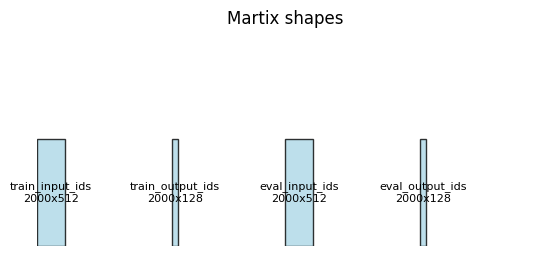

In [12]:
plot_matrices([np.matrix(encoded_train['input_ids']),
               np.matrix(encoded_train['labels']),
               np.matrix(encoded_eval['input_ids']),
               np.matrix(encoded_eval['labels'])],
              ["train_input_ids",
               "train_output_ids",
               "eval_input_ids",
               "eval_output_ids"])



Paruošiame klasifikavimo žymių žodynus:

## 2. Modelio inicializavimas ir derinimas

In [14]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8,
    return_tensors="np"
)

tf_train_dataset = model.prepare_tf_dataset(
    encoded_train,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_eval_dataset = model.prepare_tf_dataset(
    encoded_eval,
    collate_fn=data_collator
)

Ką tik gautas įspėjimas apie kai kuriuos išmestus svorius yra normalus - šiuo atveju mes pašalinome modelio bloką, atsakingą už maskuotą kalbos modeliavimą - tai yra įprasta BERT modelio užduotis, o mes norime atlikti sentimentų analizę (teksto klasifikavimą), dėl ko mums ir reikia papildomas modelio derinimas.

Norime įkelsti mūsų duomenis kaip Tensorflow duomenų rinkinius - tai bus padaryta automatiškai ir atitiks modelio architektūrą:

In [15]:
batch_size = 16

# def convert_to_tf_dataset(tokenized_dataset, batch_size=16):
#     def gen():
#         for data in tokenized_dataset:
#             yield {
#                 "input_ids": data["input_ids"],
#                 "attention_mask": data["attention_mask"],
#             }, data["output_ids"]

#     return tf.data.Dataset.from_generator(
#         gen,
#         output_signature=(
#             {
#                 "input_ids": tf.TensorSpec(shape=(512,), dtype=tf.int32),
#                 "attention_mask": tf.TensorSpec(shape=(512,), dtype=tf.int32),
#             },
#             tf.TensorSpec(shape=(128,), dtype=tf.int32),
#         ),
#     ).batch(batch_size)

# # Create train and validation datasets
# train_dataset = convert_to_tf_dataset(encoded_train)
# val_dataset = convert_to_tf_dataset(encoded_eval)

In [16]:
tf_train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'decoder_input_ids': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 128), dtype=tf.int64, name=None))>

Visi `transformers` modeliai pagal nutylėjimą gali patys pasirinkti protingą nuostolių funkciją, todėl mums nereikis dėti `loss` parametro į `compile()`. Tuo metu `transformers` rekomenduoja sukonstruoti `AdamW` tipo optimizatorių patiems:

In [17]:
num_epochs = 3

batches_per_epoch = len(encoded_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = transformers.create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=['accuracy'])

Laikas fittinti modelį:

In [18]:
model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=num_epochs
)

Epoch 1/3
125/125 [==============================] - 120s 638ms/step - loss: 42.1495 - accuracy: 7.8125e-06 - val_loss: 30.7312 - val_accuracy: 7.8125e-06
Epoch 2/3
125/125 [==============================] - 95s 758ms/step - loss: 33.2144 - accuracy: 3.9063e-04 - val_loss: 25.4763 - val_accuracy: 0.0024
Epoch 3/3
125/125 [==============================] - 80s 643ms/step - loss: 29.3770 - accuracy: 0.0010 - val_loss: 23.3326 - val_accuracy: 0.0064


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
model.save_pretrained("/content/drive/My Drive/Colab")

## 3. Modelio panaudojimas

In [26]:
sentences = ["Chapter 1 is a brief introduction, which includes an explanation of the notation used in the book. The book tries to establish a formal relation between several word-level alignment models, and it does a thorough job of describing the methods using a consistent mathematical formalization. This consistency allows the authors to describe methods in a more compact way and helps to better see the common patterns across seemingly different approaches. In this sense, introducing the notation in the first chapter makes life easier for later. The formulas are quite dense and demanding, but although a mathematically naive reader might have a hard time following them, casual readers can also get value from a higher level read of the book."]
tokenized = tokenizer(sentences, return_tensors="np", padding="longest",
                      return_token_type_ids=False)

out = model.generate(**tokenized)
out = out.numpy().tolist()
tokenizer.batch_decode(out, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:837: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['frec404 Aber404 Aber headphones Aber404 Aber404 Aber404 Aber']